<a href="https://colab.research.google.com/github/sorawit27/Konane/blob/main/Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithmic Trading
In this project, we will look at a total of nine different stock indices from different demographics, and use LSTM to try to predict its future prices. In addition, we will try to implement a simple trading algorithm based on the predictions and see how well it does compared to a random trading model or just holding stocks without selling them.

For best viewing experience and to get the correct formattings, if you're on GitHub, please open this Python notebook in Google Colab. Link should be on the very top of the page.

We start by checking that all libraries are added and are of appropriate versions

In [ ]:
# Python ≥3.5 is requiredw
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation

from keras.regularizers import L1L2
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from keras.callbacks import EarlyStopping
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path
!pip install chart_studio
import plotly.express as px

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# install data reader to read stock data from Yahoo Finance
!pip install pandas_datareader
from pandas_datareader import data as pdr

     |████████████████████████████████| 71kB 8.1MB/s 


Now we import historical stock data from Yahoo Finance for three major banks in Thailand: Kasikorn Bank, Siam Commercial Bank, Bangkok Bank; the Airport of Thailand; S&P 500 Index; NASDAQ Index; Apple; Amazon; Microsoft; Alphabet; Tesla; and Johnson & Johnson to represent a wide variety of sectors to see the effects of COVID-19 different in each.

Note that this project has been implemented using stock prices during the COVID-19 crisis, up until 10 October 2020, just before the 2020 US Presidential Election.

In [ ]:
stock_names = ['KBANK.BK','SCB.BK','KTB.BK','AOT.BK','SPY','NDAQ', 'AAPL','AMZN','MSFT','GOOG','TSLA', 'JNJ']
stock_data = []

for name in stock_names:
    try:
        data = pd.DataFrame(pdr.get_data_yahoo(name, start='2005-01-01', end='2020-10-10'))
        stock_data.append(data)
    except:
        print("Error:", sys.exc_info()[0])
        print("Description:", sys.exc_info()[1])

Let's take a look at a sample stock: this table below is for the SP500 index.

In [ ]:
stock_data[4].head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2005-01-03,121.760002,119.900002,121.559998,120.300003,55748000.0,87.794243
2005-01-04,120.540001,118.440002,120.459999,118.830002,69167600.0,86.721436
2005-01-05,119.250000,118.000000,118.739998,118.010002,65667300.0,86.123009
2005-01-06,119.150002,118.260002,118.440002,118.610001,47814700.0,86.560890
2005-01-07,119.230003,118.129997,118.970001,118.440002,55847700.0,86.436821


Now we look at all the all the stocks, but only at their adjusted closing price to account for stock splits, dividends, etc.

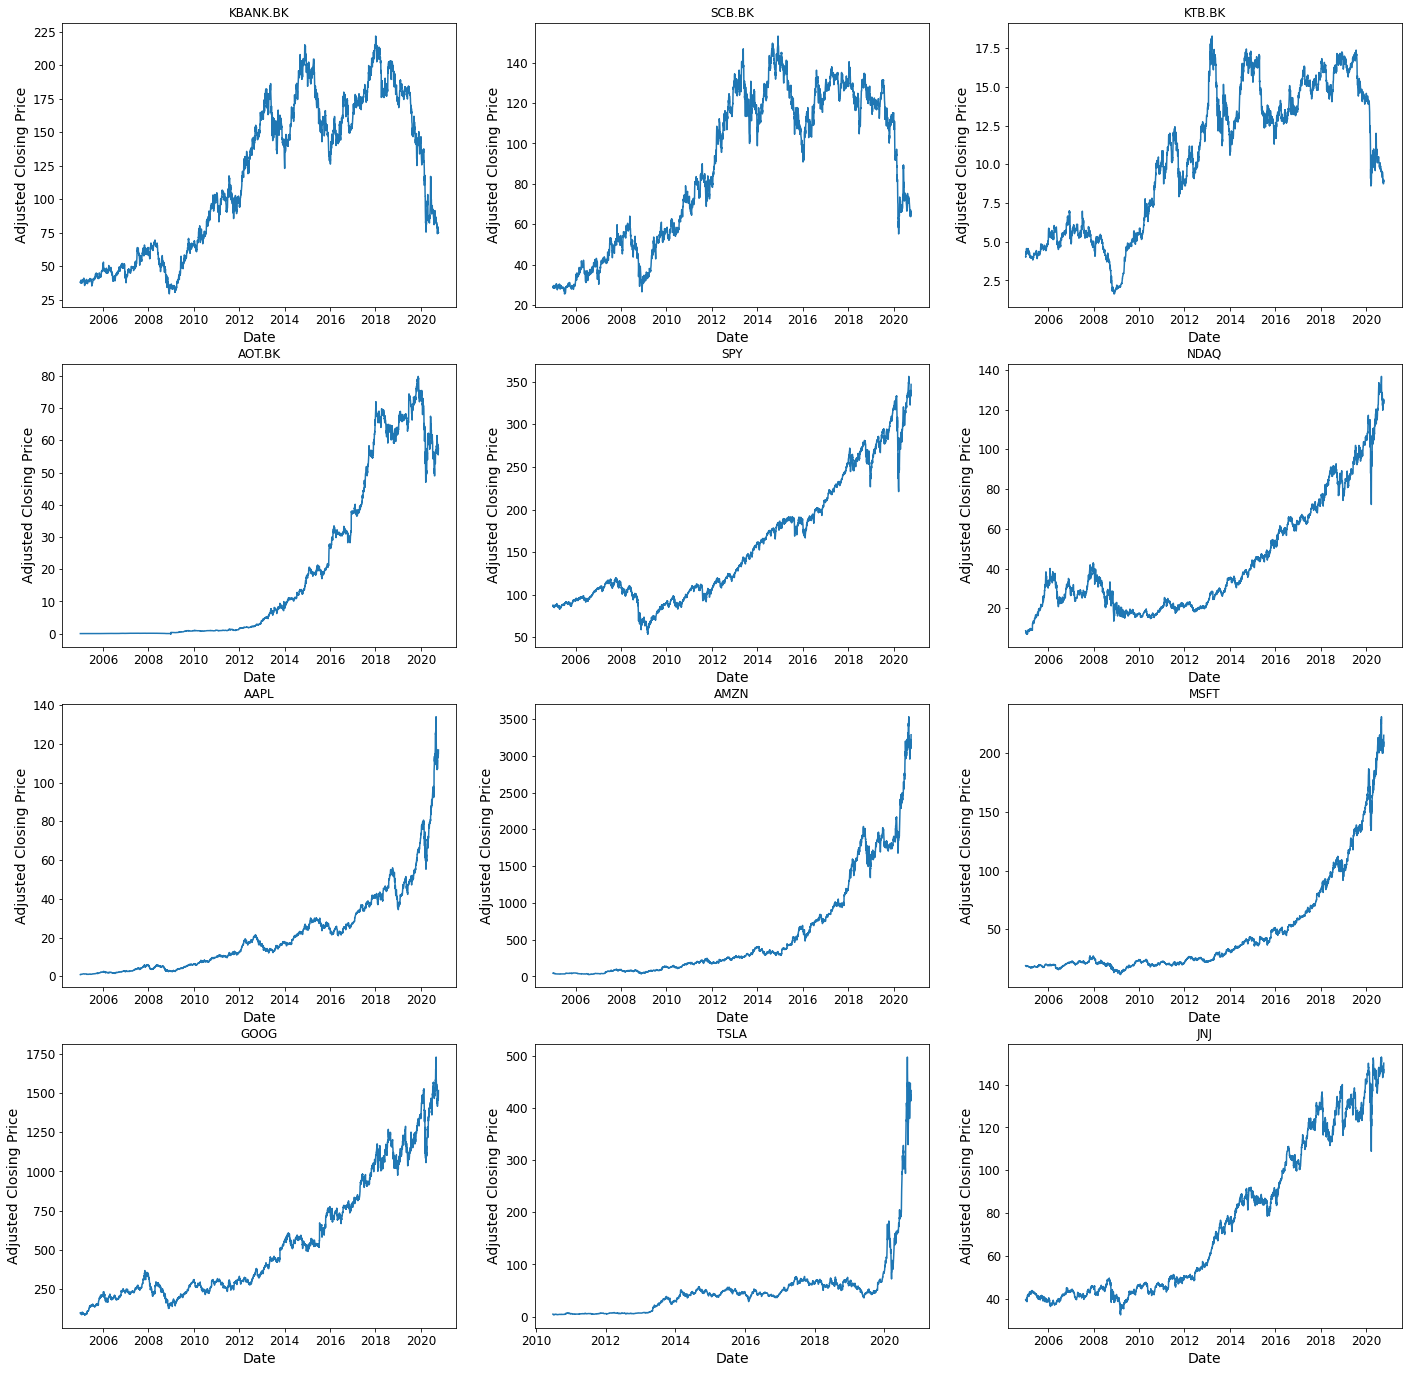

In [ ]:
fig, axs = plt.subplots(4,3, figsize=(24,24))
axs = axs.ravel()

# plot adjusted closing price of all stocks
i = 0
for stock in stock_data:
  axs[i].plot(stock.index, stock["Adj Close"])
  axs[i].set_xlabel('Date')
  axs[i].set_ylabel('Adjusted Closing Price')
  axs[i].set_title(stock_names[i])
  i = i+1

# Stock Price Prediction
Now we choose which stock we want to predict:

In [ ]:
stock_chosen = 'AOT.BK' #@param ['KBANK.BK','SCB.BK','KTB.BK','AOT.BK','SPY','NDAQ', 'AAPL','AMZN','MSFT','GOOG','TSLA', 'JNJ']

In [ ]:
index = stock_names.index(stock_chosen)
print(index)

3


In [ ]:
len = (stock_data[index].shape)[0]
print(len)

3872


Next, we split the data into 3 sets - training, validation, and testing

In [ ]:
# spit data into train/valid/test data (70/20/10)
train_split = int(len * 0.7)
valid_split = int(len * 0.9)

train_data = stock_data[index]["Adj Close"][:train_split].to_numpy()
valid_data = stock_data[index]["Adj Close"][train_split:valid_split].to_numpy()
test_data = stock_data[index]["Adj Close"][valid_split:].to_numpy()

train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(2710, 1)
(774, 1)
(388, 1)


Now we scale the data to optimize the performance of our neural network:
Important: Note that in this example, we are trying to predict stock prices with the lag of 5, i.e. using prices 5 days ago to predict today's based on historical trends 

In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = sc.fit_transform(train_data)
valid_data_scaled = sc.fit_transform(valid_data)
test_data_scaled = sc.fit_transform(test_data)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []

# 3 day lag
for i in range(60, train_split):
    X_train.append(train_data_scaled[i-55:i, 0])
    y_train.append(train_data_scaled[i, 0])
for i in range(60, valid_split-train_split):
    X_valid.append(valid_data_scaled[i-55:i, 0])
    y_valid.append(valid_data_scaled[i, 0])
for i in range(60, len-valid_split):
    X_test.append(test_data_scaled[i-55:i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test = np.array(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)

(2650, 55)
(2650,)
(714, 55)
(714,)
(328, 55)
(2650, 55, 1)
(2650,)
(714, 55, 1)
(714,)
(328, 55, 1)


Now we will start constructing our neural network: normally stock data is predicted using [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) which has proved to be advantageous in predicting gularization since they assemble "more complex patterns using smaller and simpler patterns", which is reminiscent of stock data, and use less pre-processing compared to other algorithms.

However, we will also be using Long Short-Term Memories (LSTMs), a type of RNN that can retain information over long peroids of time, while forgetting irrevelant information as the time gap grows. This is useful for analyzing time series.

For more information, see [here](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)

Possible future implementations will attempt to use other types of neural networks or machine learning algorithms (e.g. RNNs with more hyperparameter tuning) that can more accurately predict these prices, and perhaps with a more sophisticated trading algorithm than simple buy and sell orders.

We start building our neural network full of LSTM layers with some dropout and one convolutional layer at the very beginning.

Training Model from Scratch
Epoch 1/100
133/133 [==============================] - 4s 27ms/step - loss: 0.0346 - mse: 0.0346 - mae: 0.1226 - mape: 70.4509 - val_loss: 0.0165 - val_mse: 0.0165 - val_mae: 0.1077 - val_mape: 26.8802
Epoch 2/100
133/133 [==============================] - 2s 17ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.0802 - mape: 45.5619 - val_loss: 0.0046 - val_mse: 0.0046 - val_mae: 0.0540 - val_mape: 16.3087
Epoch 3/100
133/133 [==============================] - 2s 17ms/step - loss: 0.0122 - mse: 0.0122 - mae: 0.0744 - mape: 45.8895 - val_loss: 0.0060 - val_mse: 0.0060 - val_mae: 0.0606 - val_mape: 14.2647
Epoch 4/100
133/133 [==============================] - 2s 17ms/step - loss: 0.0104 - mse: 0.0104 - mae: 0.0718 - mape: 48.9923 - val_loss: 0.0054 - val_mse: 0.0054 - val_mae: 0.0571 - val_mape: 13.4928
Epoch 5/100
133/133 [==============================] - 2s 17ms/step - loss: 0.0115 - mse: 0.0115 - mae: 0.0733 - mape: 50.6075 - val_loss: 0.0066 - val_mse: 0.0066 

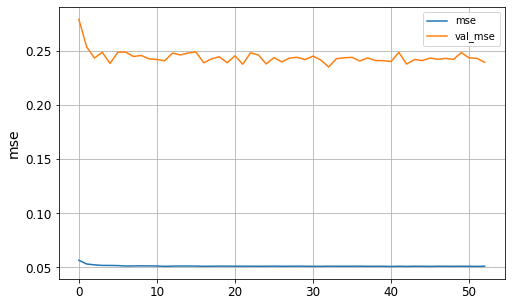

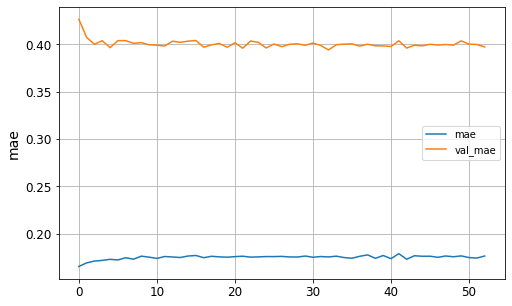

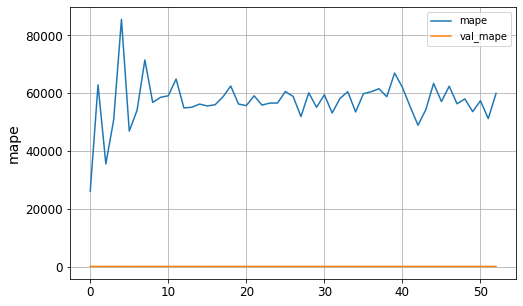

In [ ]:
def create_model(dropout_rate=0.3, lstm_unit=20, conv_unit=5, lstm_layers=2, optimizer='adam'):
    model = Sequential()
    # Adding CNN layers to model of kernel_size(length) = 5
    model.add(Conv1D(1, conv_unit, activation='relu'))
    # Adding LSTM layers with Dropout
    model.add(LSTM(units = lstm_unit, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))

    for l in range(lstm_layers):                                 
        model.add(LSTM(units = lstm_unit, return_sequences = True))
        model.add(Dropout(dropout_rate))

    model.add(LSTM(units = lstm_unit))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 1))
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics=['mse', 'mae', 'mape']) 
    return model

# checkpoint so we can resume training model if traning was interrupted 
checkpoint_cb = keras.callbacks.ModelCheckpoint("grid_model_extra.h5", save_best_only=True)

"""
try:
    model = keras.models.load_model("grid_model_extra.h5") 
    print("Continue Training Model")
except:
    print("Training Model from Scratch")
"""

# initial hyperparameters for tuning
lstm_layers= [2, 5 ,10]
conv_unit = [5, 10, 20]
batch_size = [10, 40, 100]
dropout_rate = [0.6, 0.5, 0.7]
lstm_unit = [20, 50]
epochs = [100]
optimizer = ['adam']
early_stopping = EarlyStopping(monitor='val_loss', patience=20) 

model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model) 
param_grid = dict(dropout_rate=dropout_rate, batch_size=batch_size, epochs=epochs, optimizer=optimizer)
# param_grid = dict(dropout_rate=dropout_rate, batch_size=batch_size, epochs=epochs, optimizer=optimizer, conv_unit=conv_unit, lstm_layers=lstm_layers, lstm_unit=lstm_unit)

random = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
random_result = random.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=early_stopping)

# save current model as a h5 file
random_result.best_estimator_.model.save("grid_model_extra.h5")

# plot performance of our model based on all three metrics
pd.DataFrame({key: random_result.best_estimator_.model.history.history[key] for key in ["mse", "val_mse"]}).plot(figsize=(8, 5)) 
plt.grid(True)
plt.ylabel("mse")
plt.show()

pd.DataFrame({key: random_result.best_estimator_.model.history.history[key] for key in ["mae", "val_mae"]}).plot(figsize=(8, 5))
plt.grid(True)
plt.ylabel("mae")
plt.show()

pd.DataFrame({key: random_result.best_estimator_.model.history.history[key] for key in ["mape", "val_mape"]}).plot(figsize=(8, 5))
plt.grid(True)
plt.ylabel("mape")
plt.show()

Now let's see if we can reduce the errors by adding in regularizers in the hyperparameter tuning process, since our model is overfitting, evident from the errors of validation set being a bit higher than that of the training set:


Epoch 1/100
14/14 [==============================] - 1s 97ms/step - loss: 0.3021 - mse: 0.1022 - mae: 0.2442 - mape: 144.6750 - val_loss: 0.3478 - val_mse: 0.1490 - val_mae: 0.3304 - val_mape: 89.5587
Epoch 2/100
14/14 [==============================] - 0s 17ms/step - loss: 0.2741 - mse: 0.0770 - mae: 0.2239 - mape: 177.4993 - val_loss: 0.3850 - val_mse: 0.1899 - val_mae: 0.3575 - val_mape: 75.7942
Epoch 3/100
14/14 [==============================] - 0s 18ms/step - loss: 0.2681 - mse: 0.0742 - mae: 0.2268 - mape: 205.5992 - val_loss: 0.3667 - val_mse: 0.1746 - val_mae: 0.3454 - val_mape: 79.3478
Epoch 4/100
14/14 [==============================] - 0s 18ms/step - loss: 0.2617 - mse: 0.0710 - mae: 0.2185 - mape: 189.3881 - val_loss: 0.3594 - val_mse: 0.1704 - val_mae: 0.3427 - val_mape: 80.7434
Epoch 5/100
14/14 [==============================] - 0s 18ms/step - loss: 0.2595 - mse: 0.0717 - mae: 0.2246 - mape: 206.6136 - val_loss: 0.3614 - val_mse: 0.1752 - val_mae: 0.3458 - val_mape: 79.

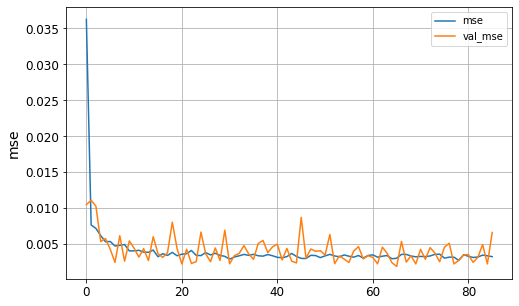

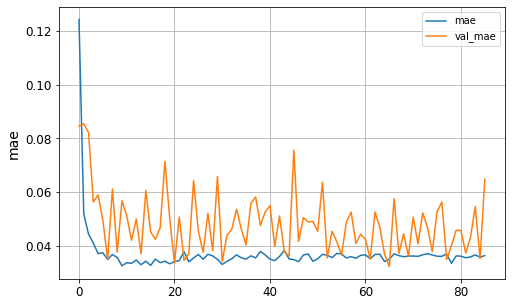

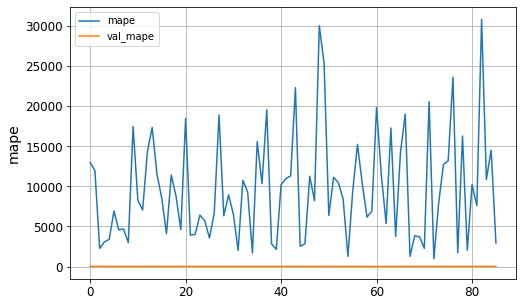

In [ ]:
def create_model(dropout_rate=0.3, lstm_unit=20, conv_unit=5, lstm_layers=2, optimizer='adam', regularizers=L1L2(l1=0.01, l2=0.00)):
    model = Sequential()
    # Adding CNN layers to model of kernel_size(length) = 5
    model.add(Conv1D(1, conv_unit, activation='relu', bias_regularizer=regularizers))
    # Adding LSTM layers with Dropout
    model.add(LSTM(units = lstm_unit, return_sequences = True, input_shape = (X_train.shape[1], 1), bias_regularizer=regularizers))
    model.add(Dropout(dropout_rate))

    for l in range(lstm_layers):                                 
        model.add(LSTM(units = lstm_unit, return_sequences = True))
        model.add(Dropout(dropout_rate))

    model.add(LSTM(units = lstm_unit))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 1))
    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics=['mse', 'mae', 'mape']) 
    return model

# checkpoint so we can resume training model if traning was interrupted 
checkpoint_cb = keras.callbacks.ModelCheckpoint("grid_model_extra_reg.h5", save_best_only=True)

"""
try:
    model = keras.models.load_model("grid_model_extra_reg.h5")  
    print("Continue Training Model")
except:
    print("Training Model from Scratch")
"""

# initial hyperparameters for tuning
lstm_layers= [2]
conv_unit = [5]
batch_size = [100]
dropout_rate = [0.5]
lstm_unit = [20]
epochs = [100]
regularizers = [L1L2(l1=0.01, l2=0.01), L1L2(l1=0.01, l2=0.0), L1L2(l1=0.0, l2=0.01), L1L2(l1=0.00, l2=0.00)]
optimizer = ['adam']
early_stopping = EarlyStopping(monitor='val_loss', patience=20) 

model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=create_model) 
param_grid = dict(dropout_rate=dropout_rate, batch_size=batch_size, epochs=epochs, optimizer=optimizer, conv_unit=conv_unit, lstm_layers=lstm_layers, lstm_unit=lstm_unit)
# param_grid = dict(dropout_rate=dropout_rate, batch_size=batch_size, epochs=epochs, optimizer=optimizer, conv_unit=conv_unit, lstm_layers=lstm_layers, lstm_unit=lstm_unit, regularizers=regularizers)
random = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
random_result = random.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=early_stopping)

# save current model as a h5 file
random_result.best_estimator_.model.save("grid_model_extra_reg.h5")

# plot performance of our model based on all three metrics
pd.DataFrame({key: random_result.best_estimator_.model.history.history[key] for key in ["mse", "val_mse"]}).plot(figsize=(8, 5))   
plt.grid(True)
plt.ylabel("mse")
plt.show()

pd.DataFrame({key: random_result.best_estimator_.model.history.history[key] for key in ["mae", "val_mae"]}).plot(figsize=(8, 5))  
plt.grid(True)
plt.ylabel("mae")
plt.show()

pd.DataFrame({key: random_result.best_estimator_.model.history.history[key] for key in ["mape", "val_mape"]}).plot(figsize=(8, 5)) 
plt.grid(True)
plt.ylabel("mape")
plt.show()

The model did better! Let's revisit the parameters of our latest model:

In [ ]:
model = random_result.best_estimator_.model
print(random_result.best_params_)

{'batch_size': 100, 'conv_unit': 5, 'dropout_rate': 0.5, 'epochs': 100, 'lstm_layers': 2, 'lstm_unit': 20, 'optimizer': 'adam'}


Now we scale the remaining data (the ones we're going to predict)

In [ ]:
dataset_total = stock_data[index]["Adj Close"]
inputs = dataset_total[stock_data[index].shape[0] - X_test.shape[0] - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

and predict the our test data set, which is the last 10 percent our data, and scale it back to its original values

In [ ]:
y_test = model.predict(X_test)
y_test = sc.inverse_transform(y_test)
y_test = y_test.reshape(y_test.shape[0])

Finally, we plot our predictions versus actual historical data

In [ ]:
# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index][valid_split+60:].index, y=y_test, mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()

As you can see, the model predicted prices quite accurately, but again, note that we are using a time lag of only 5 days. If this needs to be changed, it can easily be done above [in this cell](https://colab.research.google.com/drive/1m5iw_wvI3c2Ch-QofYmBrHegiO4JKHtd?authuser=1#scrollTo=fWXHcQQMkKAI&line=18&uniqifier=1) (i.e. when appending training,validating,testing data to all X's and y's
```
# This is formatted as code
X_train.append(train_data_scaled[i-50:i, 0])
y_train.append(train_data_scaled[i, 0])
```
This would make the lag 10 days instead of 5.

   



Now we introduce a metric to measure the performance of our model, first we have the usual mean squared error

In [ ]:
mse = sklearn.metrics.mean_squared_error(stock_data[index]['Adj Close'][valid_split+60:], y_test)
print("MSE: {}".format(mse))
print("Scaled MSE: {}".format(mse / (max(y_test) - min(y_test))))

MSE: 20.498156188379166
Scaled MSE: 1.0096308951010151


# Simple Trading Algorithm
And now we'll look at the PnL had we had \$100,000 in 
cash plus \$100,000 in stocks at the beggining of our prediction, and use all our cash at hand to buy the stock if it rises by 3%, and short sell it if the price drops by 3%.

In [ ]:
def trading_algo(index, y_test):

  # set up initial cash
  cash = 100000

  # set up initial stock
  most_recent_transaction_price = stock_data[index]['Adj Close'][valid_split+60]
  print("\n*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***")
  print("We start when the stock price is: ${:,.2f}".format(most_recent_transaction_price))
  stock_units = 100000 / most_recent_transaction_price
  initial_stock = stock_units
  print("Total Cash on Hand: ${:,.2f}".format(100000))
  print("Total Stock on Hand: ${:,.2f} ({:,.4f} units worth ${:,.2f} each)\n".format(stock_units * most_recent_transaction_price, stock_units, most_recent_transaction_price))

  df = pd.DataFrame(columns = ['Order', 'Date', 'Price', '# of stocks']) 

  for i in range(y_test.size):

    # if price rises more than 3 percent from last transction price then buy using all our cash, if no cash left then do nothing
    if(y_test[i] / most_recent_transaction_price >= 1.03 and cash != 0):
      current_date = stock_data[index].index[valid_split+60+i]
      current_price = stock_data[index]['Adj Close'][valid_split+60+i]
      transaction_units = cash / current_price
      # add order to dataframe
      new_row = {'Order':'Buy', 'Date':current_date, 'Price':"${:,.2f}".format(current_price), '# of stocks':"{:,.4f}".format(transaction_units)}
      df = df.append(new_row, ignore_index=True)
      stock_units = stock_units + transaction_units
      cash = 0
      most_recent_transaction_price = current_price

    # if price drops more than 3 percent from last transction price then sell all remaining stocks into cash, if everything is already sold then do nothing
    elif(y_test[i] / most_recent_transaction_price <= 0.97 and stock_units != 0):
      current_date = stock_data[index].index[valid_split+60+i]
      current_price = stock_data[index]['Adj Close'][valid_split+60+i]
      # add order to dataframe
      new_row = {'Order':'Sell', 'Date':current_date, 'Price':"${:,.2f}".format(current_price), '# of stocks':"{:,.4f}".format(stock_units)}
      df = df.append(new_row, ignore_index=True)
      cash = cash + stock_units * current_price
      stock_units = 0
      most_recent_transaction_price = current_price

  # print list of all orders
  display(df)

  final_stock_price = stock_data[index]['Adj Close'][-1]
  print("\nTotal Cash on Hand: ${:,.2f}".format(cash))
  print("Total Stock on Hand: ${:,.2f} ({:,.4f} units worth ${:,.2f} each)".format(stock_units * final_stock_price, stock_units, final_stock_price))
  print("Total Profit: ${:,.2f} over {} days".format(cash + (stock_units * final_stock_price) - 200000, y_test.size))

  print("\n*** Had we held to stock without selling: ***")
  print("Total Cash on Hand: ${:,.2f}".format(100000))
  print("Total Stock on Hand: ${:,.2f} ({:,.4f} units worth ${:,.2f} each)".format(initial_stock * final_stock_price, initial_stock, final_stock_price))
  print("Total Profit: ${:,.2f} over {} days".format(100000 + (initial_stock * final_stock_price) - 200000, y_test.size))

index = 3 # AOT  
trading_algo(index, y_test)


*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $65.32
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (1,531.0120 units worth $65.32 each)



,Order,Date,Price,# of stocks
0,Buy,2019-07-02,$72.96,"1,370.6695"
1,Sell,2019-07-03,$73.94,"2,901.6815"



Total Cash on Hand: $214,558.90
Total Stock on Hand: $0.00 (0.0000 units worth $57.50 each)
Total Profit: $14,558.90 over 328 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $88,033.19 (1,531.0120 units worth $57.50 each)
Total Profit: $-11,966.81 over 328 days


Nnow we're going to look at buying and selling randomly - each day we have a 50/50 chance of buying with all the money we have, or selling all the stocks we have

In [ ]:
import random 

def random_algo(index, y_test):
    
  # set up initial cash
  cash = 100000

  # set up initial stock
  print("\n*** This is a random model - there's a 50/50 chance of buying or selling every single day ***\n")
  stock_units = 100000 / stock_data[index]['Adj Close'][valid_split+60]
  initial_stock = stock_units

  df = pd.DataFrame(columns = ['Order', 'Date', 'Price', '# of stocks']) 

  for i in range(y_test.size):
    # randomize whether buying or selling; 0 is buy and 1 is sell
    decider = random.randint(0,1)

    # if randomly buy
    if(decider == 0 and cash != 0):
      current_date = stock_data[index].index[valid_split+60+i]
      current_price = stock_data[index]['Adj Close'][valid_split+60+i]
      transaction_units = cash / current_price
      # add order to dataframe
      new_row = {'Order':'Buy', 'Date':current_date, 'Price':"${:,.2f}".format(current_price), '# of stocks':"{:,.4f}".format(transaction_units)}
      df = df.append(new_row, ignore_index=True)
      stock_units = stock_units + transaction_units
      cash = 0

    # if randomly sell
    elif(decider == 1 and stock_units != 0):
      current_date = stock_data[index].index[valid_split+60+i]
      current_price = stock_data[index]['Adj Close'][valid_split+60+i]
      # add order to dataframe
      new_row = {'Order':'Sell', 'Date':current_date, 'Price':"${:,.2f}".format(current_price), '# of stocks':"{:,.4f}".format(stock_units)}
      df = df.append(new_row, ignore_index=True)
      cash = cash + stock_units * current_price
      stock_units = 0

  # print list of all orders
  display(df)

  final_stock_price = stock_data[index]['Adj Close'][-1]
  print("\nTotal Cash on Hand: ${:,.2f}".format(cash))
  print("Total Stock on Hand: ${:,.2f} ({:,.4f} units worth ${:,.2f} each)".format(stock_units * final_stock_price, stock_units, final_stock_price))
  print("Total Profit: ${:,.2f} over {} days".format(cash + (stock_units * final_stock_price) - 200000, y_test.size))

random_algo(index, y_test)


*** This is a random model - there's a 50/50 chance of buying or selling every single day ***



,Order,Date,Price,# of stocks
0,Buy,2019-06-11,$65.32,"1,531.0120"
1,Sell,2019-06-13,$65.56,"3,062.0239"
2,Buy,2019-06-14,$65.81,"3,050.5557"
3,Sell,2019-06-17,$65.56,"3,050.5557"
4,Buy,2019-06-18,$67.04,"2,983.2640"
...,...,...,...,...
158,Buy,2020-09-28,$58.75,"2,103.3386"
159,Sell,2020-09-29,$58.00,"2,103.3386"
160,Buy,2020-10-01,$56.50,"2,159.1795"
161,Sell,2020-10-02,$56.00,"2,159.1795"



Total Cash on Hand: $0.00
Total Stock on Hand: $121,442.06 (2,112.0358 units worth $57.50 each)
Total Profit: $-78,557.94 over 328 days


Now let's use the **same** model to predict stocks in the other sectors.

In [ ]:
#@title Kasikorn Bank
index = 0 # KBANK

# spit data into train/valid/test data (70/20/10)
len = (stock_data[index].shape)[0]
train_split = int(len * 0.7)
valid_split = int(len * 0.9)

train_data = stock_data[index]["Adj Close"][:train_split].to_numpy()
valid_data = stock_data[index]["Adj Close"][train_split:valid_split].to_numpy()
test_data = stock_data[index]["Adj Close"][valid_split:].to_numpy()

train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = sc.fit_transform(train_data)
valid_data_scaled = sc.fit_transform(valid_data)
test_data_scaled = sc.fit_transform(test_data)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []

# 55 day lag
for i in range(60, train_split):
    X_train.append(train_data_scaled[i-55:i, 0])
    y_train.append(train_data_scaled[i, 0])
for i in range(60, valid_split-train_split):
    X_valid.append(valid_data_scaled[i-55:i, 0])
    y_valid.append(valid_data_scaled[i, 0])
for i in range(60, len-valid_split):
    X_test.append(test_data_scaled[i-55:i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test = np.array(X_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

dataset_total = stock_data[index]["Adj Close"]
inputs = dataset_total[stock_data[index].shape[0] - X_test.shape[0] - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

y_test = model.predict(X_test)
y_test = sc.inverse_transform(y_test)
y_test = y_test.reshape(y_test.shape[0])

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index][valid_split+60:].index, y=y_test, mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()


mse = sklearn.metrics.mean_squared_error(stock_data[index]['Adj Close'][valid_split+60:], y_test)
print("MSE: {}".format(mse))
print("Scaled MSE: {}".format(mse / (max(y_test) - min(y_test))))

trading_algo(index, y_test)
random_algo(index, y_test)

MSE: 104.22221613174699
Scaled MSE: 1.222086230393183

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $183.76
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (544.1935 units worth $183.76 each)



,Order,Date,Price,# of stocks
0,Sell,2019-06-11,$183.76,544.1935



Total Cash on Hand: $200,000.00
Total Stock on Hand: $0.00 (0.0000 units worth $75.25 each)
Total Profit: $0.00 over 328 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $40,950.56 (544.1935 units worth $75.25 each)
Total Profit: $-59,049.44 over 328 days

*** This is a random model - there's a 50/50 chance of buying or selling every single day ***



,Order,Date,Price,# of stocks
0,Sell,2019-06-11,$183.76,544.1935
1,Buy,2019-06-12,$184.23,"1,085.5746"
2,Sell,2019-06-18,$180.90,"1,085.5746"
3,Buy,2019-06-25,$181.85,"1,079.8910"
4,Sell,2019-06-27,$179.47,"1,079.8910"
...,...,...,...,...
143,Buy,2020-09-29,$78.00,"1,427.2852"
144,Sell,2020-10-05,$75.50,"1,427.2852"
145,Buy,2020-10-07,$74.75,"1,441.6058"
146,Sell,2020-10-08,$75.50,"1,441.6058"



Total Cash on Hand: $0.00
Total Stock on Hand: $108,841.24 (1,446.3952 units worth $75.25 each)
Total Profit: $-91,158.76 over 328 days


In [ ]:
#@title and SCB (another Thai Bank)
index = 1 # SCB

# spit data into train/valid/test data (70/20/10)
len = (stock_data[index].shape)[0]
train_split = int(len * 0.7)
valid_split = int(len * 0.9)

train_data = stock_data[index]["Adj Close"][:train_split].to_numpy()
valid_data = stock_data[index]["Adj Close"][train_split:valid_split].to_numpy()
test_data = stock_data[index]["Adj Close"][valid_split:].to_numpy()

train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = sc.fit_transform(train_data)
valid_data_scaled = sc.fit_transform(valid_data)
test_data_scaled = sc.fit_transform(test_data)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []

# 55 day lag
for i in range(60, train_split):
    X_train.append(train_data_scaled[i-55:i, 0])
    y_train.append(train_data_scaled[i, 0])
for i in range(60, valid_split-train_split):
    X_valid.append(valid_data_scaled[i-55:i, 0])
    y_valid.append(valid_data_scaled[i, 0])
for i in range(60, len-valid_split):
    X_test.append(test_data_scaled[i-55:i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test = np.array(X_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

dataset_total = stock_data[index]["Adj Close"]
inputs = dataset_total[stock_data[index].shape[0] - X_test.shape[0] - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

y_test = model.predict(X_test)
y_test = sc.inverse_transform(y_test)
y_test = y_test.reshape(y_test.shape[0])

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index][valid_split+60:].index, y=y_test, mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()


mse = sklearn.metrics.mean_squared_error(stock_data[index]['Adj Close'][valid_split+60:], y_test)
print("MSE: {}".format(mse))
print("Scaled MSE: {}".format(mse / (max(y_test) - min(y_test))))

trading_algo(index, y_test)
random_algo(index, y_test)

MSE: 58.616443410222395
Scaled MSE: 1.1378223093685413

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $122.65
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (815.3239 units worth $122.65 each)



,Order,Date,Price,# of stocks
0,Sell,2019-06-11,$122.65,815.3239



Total Cash on Hand: $200,000.00
Total Stock on Hand: $0.00 (0.0000 units worth $66.00 each)
Total Profit: $0.00 over 328 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $53,811.38 (815.3239 units worth $66.00 each)
Total Profit: $-46,188.62 over 328 days

*** This is a random model - there's a 50/50 chance of buying or selling every single day ***



,Order,Date,Price,# of stocks
0,Sell,2019-06-11,$122.65,815.3239
1,Buy,2019-06-17,$123.12,"1,624.4945"
2,Sell,2019-06-18,$124.04,"1,624.4945"
3,Buy,2019-06-20,$125.44,"1,606.4447"
4,Sell,2019-06-24,$124.51,"1,606.4447"
...,...,...,...,...
153,Buy,2020-09-28,$67.25,"1,540.5111"
154,Sell,2020-09-30,$65.00,"1,540.5111"
155,Buy,2020-10-02,$63.75,"1,570.7172"
156,Sell,2020-10-05,$64.25,"1,570.7172"



Total Cash on Hand: $0.00
Total Stock on Hand: $100,159.79 (1,517.5726 units worth $66.00 each)
Total Profit: $-99,840.21 over 328 days


In [ ]:
#@title Now let's look at the NASDAQ index
index = 5 # NASDAQ

# spit data into train/valid/test data (70/20/10)
len = (stock_data[index].shape)[0]
train_split = int(len * 0.7)
valid_split = int(len * 0.9)

train_data = stock_data[index]["Adj Close"][:train_split].to_numpy()
valid_data = stock_data[index]["Adj Close"][train_split:valid_split].to_numpy()
test_data = stock_data[index]["Adj Close"][valid_split:].to_numpy()

train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = sc.fit_transform(train_data)
valid_data_scaled = sc.fit_transform(valid_data)
test_data_scaled = sc.fit_transform(test_data)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []

# 55 day lag
for i in range(60, train_split):
    X_train.append(train_data_scaled[i-55:i, 0])
    y_train.append(train_data_scaled[i, 0])
for i in range(60, valid_split-train_split):
    X_valid.append(valid_data_scaled[i-55:i, 0])
    y_valid.append(valid_data_scaled[i, 0])
for i in range(60, len-valid_split):
    X_test.append(test_data_scaled[i-55:i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test = np.array(X_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

dataset_total = stock_data[index]["Adj Close"]
inputs = dataset_total[stock_data[index].shape[0] - X_test.shape[0] - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

y_test = model.predict(X_test)
y_test = sc.inverse_transform(y_test)
y_test = y_test.reshape(y_test.shape[0])

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index][valid_split+60:].index, y=y_test, mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()


mse = sklearn.metrics.mean_squared_error(stock_data[index]['Adj Close'][valid_split+60:], y_test)
print("MSE: {}".format(mse))
print("Scaled MSE: {}".format(mse / (max(y_test) - min(y_test))))

trading_algo(index, y_test)
random_algo(index, y_test)

MSE: 41.95486377182516
Scaled MSE: 1.1772006260941805

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $92.73
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (1,078.3846 units worth $92.73 each)



,Order,Date,Price,# of stocks
0,Sell,2019-06-11,$92.73,"1,078.3846"
1,Buy,2019-07-18,$100.90,"1,982.1812"
2,Sell,2019-07-19,$99.52,"1,982.1812"
3,Buy,2019-12-31,$105.76,"1,865.3043"
4,Sell,2020-03-24,$82.34,"1,865.3043"
5,Buy,2020-03-25,$86.28,"1,780.1474"



Total Cash on Hand: $0.00
Total Stock on Hand: $222,625.23 (1,780.1474 units worth $125.06 each)
Total Profit: $22,625.23 over 338 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $134,862.78 (1,078.3846 units worth $125.06 each)
Total Profit: $34,862.78 over 338 days

*** This is a random model - there's a 50/50 chance of buying or selling every single day ***



,Order,Date,Price,# of stocks
0,Sell,2019-06-11,$92.73,"1,078.3846"
1,Buy,2019-06-20,$95.62,"2,091.6939"
2,Sell,2019-06-21,$96.15,"2,091.6939"
3,Buy,2019-06-24,$94.77,"2,122.3554"
4,Sell,2019-06-26,$92.55,"2,122.3554"
...,...,...,...,...
156,Sell,2020-09-30,$122.71,"1,687.5624"
157,Buy,2020-10-05,$124.87,"1,658.3709"
158,Sell,2020-10-06,$123.57,"1,658.3709"
159,Buy,2020-10-07,$122.98,"1,666.3269"



Total Cash on Hand: $208,390.84
Total Stock on Hand: $0.00 (0.0000 units worth $125.06 each)
Total Profit: $8,390.84 over 338 days


In [ ]:
#@title and move on to the tech sector with Amazon
index = 7 # Amazon

# spit data into train/valid/test data (70/20/10)
len = (stock_data[index].shape)[0]
train_split = int(len * 0.7)
valid_split = int(len * 0.9)

train_data = stock_data[index]["Adj Close"][:train_split].to_numpy()
valid_data = stock_data[index]["Adj Close"][train_split:valid_split].to_numpy()
test_data = stock_data[index]["Adj Close"][valid_split:].to_numpy()

train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = sc.fit_transform(train_data)
valid_data_scaled = sc.fit_transform(valid_data)
test_data_scaled = sc.fit_transform(test_data)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []

# 55 day lag
for i in range(60, train_split):
    X_train.append(train_data_scaled[i-55:i, 0])
    y_train.append(train_data_scaled[i, 0])
for i in range(60, valid_split-train_split):
    X_valid.append(valid_data_scaled[i-55:i, 0])
    y_valid.append(valid_data_scaled[i, 0])
for i in range(60, len-valid_split):
    X_test.append(test_data_scaled[i-55:i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test = np.array(X_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

dataset_total = stock_data[index]["Adj Close"]
inputs = dataset_total[stock_data[index].shape[0] - X_test.shape[0] - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

y_test = model.predict(X_test)
y_test = sc.inverse_transform(y_test)
y_test = y_test.reshape(y_test.shape[0])

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index][valid_split+60:].index, y=y_test, mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()


mse = sklearn.metrics.mean_squared_error(stock_data[index]['Adj Close'][valid_split+60:], y_test)
print("MSE: {}".format(mse))
print("Scaled MSE: {}".format(mse / (max(y_test) - min(y_test))))

trading_algo(index, y_test)
random_algo(index, y_test)

MSE: 26178.789882779827
Scaled MSE: 19.061694755661655

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $1,863.70
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (53.6567 units worth $1,863.70 each)



,Order,Date,Price,# of stocks
0,Buy,2019-07-17,"$1,992.03",50.2000
1,Sell,2019-07-18,"$1,977.90",103.8568
2,Buy,2020-02-27,"$1,884.30",109.0157



Total Cash on Hand: $0.00
Total Stock on Hand: $358,296.41 (109.0157 units worth $3,286.65 each)
Total Profit: $158,296.41 over 338 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $176,350.81 (53.6567 units worth $3,286.65 each)
Total Profit: $76,350.81 over 338 days

*** This is a random model - there's a 50/50 chance of buying or selling every single day ***



,Order,Date,Price,# of stocks
0,Sell,2019-06-11,"$1,863.70",53.6567
1,Buy,2019-06-12,"$1,855.32",107.7981
2,Sell,2019-06-17,"$1,886.03",107.7981
3,Buy,2019-06-21,"$1,911.30",106.3729
4,Sell,2019-06-25,"$1,878.27",106.3729
...,...,...,...,...
164,Sell,2020-10-02,"$3,125.00",73.8465
165,Buy,2020-10-06,"$3,099.96",74.4430
166,Sell,2020-10-07,"$3,195.69",74.4430
167,Buy,2020-10-08,"$3,190.55",74.5629



Total Cash on Hand: $245,062.10
Total Stock on Hand: $0.00 (0.0000 units worth $3,286.65 each)
Total Profit: $45,062.10 over 338 days


In [ ]:
#@title Google (Alphabet)
index = 9 # Alphabet

# spit data into train/valid/test data (70/20/10)
len = (stock_data[index].shape)[0]
train_split = int(len * 0.7)
valid_split = int(len * 0.9)

train_data = stock_data[index]["Adj Close"][:train_split].to_numpy()
valid_data = stock_data[index]["Adj Close"][train_split:valid_split].to_numpy()
test_data = stock_data[index]["Adj Close"][valid_split:].to_numpy()

train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = sc.fit_transform(train_data)
valid_data_scaled = sc.fit_transform(valid_data)
test_data_scaled = sc.fit_transform(test_data)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []

# 55 day lag
for i in range(60, train_split):
    X_train.append(train_data_scaled[i-55:i, 0])
    y_train.append(train_data_scaled[i, 0])
for i in range(60, valid_split-train_split):
    X_valid.append(valid_data_scaled[i-55:i, 0])
    y_valid.append(valid_data_scaled[i, 0])
for i in range(60, len-valid_split):
    X_test.append(test_data_scaled[i-55:i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test = np.array(X_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

dataset_total = stock_data[index]["Adj Close"]
inputs = dataset_total[stock_data[index].shape[0] - X_test.shape[0] - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

y_test = model.predict(X_test)
y_test = sc.inverse_transform(y_test)
y_test = y_test.reshape(y_test.shape[0])

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index][valid_split+60:].index, y=y_test, mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()


mse = sklearn.metrics.mean_squared_error(stock_data[index]['Adj Close'][valid_split+60:], y_test)
print("MSE: {}".format(mse))
print("Scaled MSE: {}".format(mse / (max(y_test) - min(y_test))))

trading_algo(index, y_test)
random_algo(index, y_test)

MSE: 5773.86652397867
Scaled MSE: 12.903135620830856

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $1,078.72
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (92.7025 units worth $1,078.72 each)



,Order,Date,Price,# of stocks
0,Buy,2019-06-11,"$1,078.72",92.7025



Total Cash on Hand: $0.00
Total Stock on Hand: $280,929.25 (185.4049 units worth $1,515.22 each)
Total Profit: $80,929.25 over 338 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $140,464.63 (92.7025 units worth $1,515.22 each)
Total Profit: $40,464.63 over 338 days

*** This is a random model - there's a 50/50 chance of buying or selling every single day ***



,Order,Date,Price,# of stocks
0,Sell,2019-06-11,"$1,078.72",92.7025
1,Buy,2019-06-13,"$1,088.77",183.6935
2,Sell,2019-06-14,"$1,085.35",183.6935
3,Buy,2019-06-17,"$1,092.50",182.4913
4,Sell,2019-06-19,"$1,102.33",182.4913
...,...,...,...,...
181,Buy,2020-09-29,"$1,469.33",109.6437
182,Sell,2020-10-01,"$1,490.09",109.6437
183,Buy,2020-10-05,"$1,486.02",109.9440
184,Sell,2020-10-06,"$1,453.44",109.9440



Total Cash on Hand: $0.00
Total Stock on Hand: $162,946.83 (107.5400 units worth $1,515.22 each)
Total Profit: $-37,053.17 over 338 days


In [ ]:
#@title Tesla
index = 10 # Tesla

# spit data into train/valid/test data (70/20/10)
len = (stock_data[index].shape)[0]
train_split = int(len * 0.7)
valid_split = int(len * 0.9)

train_data = stock_data[index]["Adj Close"][:train_split].to_numpy()
valid_data = stock_data[index]["Adj Close"][train_split:valid_split].to_numpy()
test_data = stock_data[index]["Adj Close"][valid_split:].to_numpy()

train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = sc.fit_transform(train_data)
valid_data_scaled = sc.fit_transform(valid_data)
test_data_scaled = sc.fit_transform(test_data)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []

# 55 day lag
for i in range(60, train_split):
    X_train.append(train_data_scaled[i-55:i, 0])
    y_train.append(train_data_scaled[i, 0])
for i in range(60, valid_split-train_split):
    X_valid.append(valid_data_scaled[i-55:i, 0])
    y_valid.append(valid_data_scaled[i, 0])
for i in range(60, len-valid_split):
    X_test.append(test_data_scaled[i-55:i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test = np.array(X_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

dataset_total = stock_data[index]["Adj Close"]
inputs = dataset_total[stock_data[index].shape[0] - X_test.shape[0] - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

y_test = model.predict(X_test)
y_test = sc.inverse_transform(y_test)
y_test = y_test.reshape(y_test.shape[0])

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index][valid_split+60:].index, y=y_test, mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()


mse = sklearn.metrics.mean_squared_error(stock_data[index]['Adj Close'][valid_split+60:], y_test)
print("MSE: {}".format(mse))
print("Scaled MSE: {}".format(mse / (max(y_test) - min(y_test))))

trading_algo(index, y_test)
random_algo(index, y_test)

MSE: 2243.8502247224073
Scaled MSE: 7.408640700190212

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $86.08
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (1,161.7641 units worth $86.08 each)



,Order,Date,Price,# of stocks
0,Sell,2019-12-27,$86.08,"1,161.7641"
1,Buy,2020-01-17,$102.10,"1,958.8639"
2,Sell,2020-01-21,$109.44,"1,958.8639"
3,Buy,2020-02-10,$154.26,"1,389.7552"
4,Sell,2020-02-11,$154.88,"1,389.7552"
5,Buy,2020-06-11,$194.57,"1,106.2443"
6,Sell,2020-06-12,$187.06,"1,106.2443"
7,Buy,2020-07-09,$278.86,742.0663
8,Sell,2020-07-10,$308.93,742.0663
9,Buy,2020-08-27,$447.75,511.9967



Total Cash on Hand: $226,650.71
Total Stock on Hand: $0.00 (0.0000 units worth $434.00 each)
Total Profit: $26,650.71 over 199 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $504,205.61 (1,161.7641 units worth $434.00 each)
Total Profit: $404,205.61 over 199 days

*** This is a random model - there's a 50/50 chance of buying or selling every single day ***



,Order,Date,Price,# of stocks
0,Buy,2019-12-27,$86.08,"1,161.7641"
1,Sell,2020-01-02,$86.05,"2,323.5281"
2,Buy,2020-01-08,$98.43,"2,031.3757"
3,Sell,2020-01-10,$95.63,"2,031.3757"
4,Buy,2020-01-13,$104.97,"1,850.5930"
...,...,...,...,...
96,Buy,2020-09-25,$407.34,888.3600
97,Sell,2020-10-01,$448.16,888.3600
98,Buy,2020-10-02,$415.09,959.1352
99,Sell,2020-10-06,$413.98,959.1352



Total Cash on Hand: $0.00
Total Stock on Hand: $404,595.35 (932.2473 units worth $434.00 each)
Total Profit: $204,595.35 over 199 days


In [ ]:
#@title and Johnson&Johnson
index = 11 # JnJ

# spit data into train/valid/test data (70/20/10)
len = (stock_data[index].shape)[0]
train_split = int(len * 0.7)
valid_split = int(len * 0.9)

train_data = stock_data[index]["Adj Close"][:train_split].to_numpy()
valid_data = stock_data[index]["Adj Close"][train_split:valid_split].to_numpy()
test_data = stock_data[index]["Adj Close"][valid_split:].to_numpy()

train_data = train_data.reshape(-1,1)
valid_data = valid_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
train_data_scaled = sc.fit_transform(train_data)
valid_data_scaled = sc.fit_transform(valid_data)
test_data_scaled = sc.fit_transform(test_data)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
X_valid = []
y_valid = []
X_test = []

# 55 day lag
for i in range(60, train_split):
    X_train.append(train_data_scaled[i-55:i, 0])
    y_train.append(train_data_scaled[i, 0])
for i in range(60, valid_split-train_split):
    X_valid.append(valid_data_scaled[i-55:i, 0])
    y_valid.append(valid_data_scaled[i, 0])
for i in range(60, len-valid_split):
    X_test.append(test_data_scaled[i-55:i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_valid, y_valid = np.array(X_valid), np.array(y_valid)
X_test = np.array(X_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

dataset_total = stock_data[index]["Adj Close"]
inputs = dataset_total[stock_data[index].shape[0] - X_test.shape[0] - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

y_test = model.predict(X_test)
y_test = sc.inverse_transform(y_test)
y_test = y_test.reshape(y_test.shape[0])

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index][valid_split+60:].index, y=y_test, mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()

mse = sklearn.metrics.mean_squared_error(stock_data[index]['Adj Close'][valid_split+60:], y_test)
print("MSE: {}".format(mse))
print("Scaled MSE: {}".format(mse / (max(y_test) - min(y_test))))

trading_algo(index, y_test)
random_algo(index, y_test)

MSE: 32.474396500147854
Scaled MSE: 1.5960418831104952

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $134.14
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (745.4950 units worth $134.14 each)



,Order,Date,Price,# of stocks
0,Sell,2019-06-11,$134.14,745.4950
1,Buy,2020-01-16,$144.28,"1,386.2160"
2,Sell,2020-01-17,$145.22,"1,386.2160"



Total Cash on Hand: $201,309.07
Total Stock on Hand: $0.00 (0.0000 units worth $149.93 each)
Total Profit: $1,309.07 over 338 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $111,770.71 (745.4950 units worth $149.93 each)
Total Profit: $11,770.71 over 338 days

*** This is a random model - there's a 50/50 chance of buying or selling every single day ***



,Order,Date,Price,# of stocks
0,Buy,2019-06-11,$134.14,745.4950
1,Sell,2019-06-12,$135.96,"1,490.9899"
2,Buy,2019-06-17,$133.81,"1,514.9413"
3,Sell,2019-06-18,$134.57,"1,514.9413"
4,Buy,2019-06-19,$134.78,"1,512.5684"
...,...,...,...,...
166,Buy,2020-09-25,$144.65,"1,505.3435"
167,Sell,2020-09-28,$146.09,"1,505.3435"
168,Buy,2020-10-01,$146.30,"1,503.1976"
169,Sell,2020-10-02,$145.23,"1,503.1976"



Total Cash on Hand: $0.00
Total Stock on Hand: $222,346.08 (1,483.0172 units worth $149.93 each)
Total Profit: $22,346.08 over 338 days


As can bee seen in the graphs above, the model did quite well in predicting the majority of the stocks. It did surprisingly well for KBank and SCB, both of which are also Thai stocks and do not reflect the trend of stocks in the United States (the baseline model was predicting the Airport of Thailand stock). This is also probably due to the decrease in price of both stocks not being dramatic. However, for tech stocks such as Amazon and Alphabet, the model did quite poorly, probably due to both stock prices increasing at a much higher rate than the rest. Tesla, in particular, tripled in value in 2020 alone due to a particular of factors, such as stock splitting in the year and the success of other companies founded by Elon Musk such as SpaceX and The Boring Company. The model did quite well on NASDAQ and J&J, both of which showed similar growth patterns.

Our trading algorithm does quite well in comparison to a random model or just holding on to stocks, only in the exception of the tech stocks, which overall always had an upward trend, and stocks with high volatility. Here's a summary table:

>Stock Name | Model Scaled MSE | Simple Algo | Just Holding | Random Buy/Sell
>:--- | ---: | ---: | ---: | ---:
>Airport of Thailand | 1.0096 | \$14,558.90 | \$-11,966.81 | \$-78,557.94
>Kasikorn Bank | 1.2221 | \$0.00 | \$-59,049.44 | \$-91,158.76
>SCB | 1.1378 | \$0.00 | \$-46,188.62 | \$-99,840.21 
>NASDAQ | 1.1772 | \$22,625.23 | \$34,862.78 | \$8,390.84  
>Amazon | 19.0617 | \$158,296.41 | \$76,350.81 | \$45,062.10
>Google | 12.9031 | \$80,929.25 | \$ 40,464.63 | \$-37,053.17
>~~Tesla~~ | ~~7.4086~~ | ~~\$26,650.71~~ | ~~\$404,205.61~~ | ~~\$204,595.35~~
>Johnson & Johnson | 1.5960 | \$1,309.07 | \$11,770.71 | \$22,346.08
>Total | | \$277,718.86| \$46,244.06| \$-26,296.71

As expected, in totality Random Buy/Sell performed the worst, and our simple buy/sell model with a 3% tolerance did the best. Tesla was removed from calculating the total because it was an extreme outlier due to stock splitting and other factors in 2020. 



Now let's use our model to try to predict Apple right from the beginning (no train-teset-valid split) 

In [ ]:
index = 6 # Apple

# no splitting data
valid_split = 0

len = (stock_data[index].shape)[0]

test_data = stock_data[index]["Adj Close"].to_numpy()

test_data = test_data.reshape(-1,1)

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
test_data_scaled = sc.fit_transform(test_data)

# Creating a data structure with 60 time-steps and 1 output
X_test = []

for i in range(60, len):
    X_test.append(test_data_scaled[i-55:i, 0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

dataset_total = stock_data[index]["Adj Close"]
inputs = dataset_total.values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

y_test = model.predict(X_test)
y_test = sc.inverse_transform(y_test)
y_test = y_test.reshape(y_test.shape[0])

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Adjusted Closing Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index].index[60:], y=y_test, mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()


mse = sklearn.metrics.mean_squared_error(stock_data[index]['Adj Close'][valid_split+60:], y_test)
print("MSE: {}".format(mse))
print("Scaled MSE: {}".format(mse / (max(y_test) - min(y_test))))

trading_algo(index, y_test)
random_algo(index, y_test)

MSE: 11.3444863588954
Scaled MSE: 0.10985701033811053

*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $1.27
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (78,530.9229 units worth $1.27 each)



,Order,Date,Price,# of stocks
0,Buy,2005-03-31,$1.27,"78,530.9229"



Total Cash on Hand: $0.00
Total Stock on Hand: $18,339,883.52 (157,061.8457 units worth $116.77 each)
Total Profit: $18,139,883.52 over 3911 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $9,169,941.76 (78,530.9229 units worth $116.77 each)
Total Profit: $9,069,941.76 over 3911 days

*** This is a random model - there's a 50/50 chance of buying or selling every single day ***



,Order,Date,Price,# of stocks
0,Buy,2005-03-31,$1.27,"78,530.9229"
1,Sell,2005-04-01,$1.25,"157,061.8457"
2,Buy,2005-04-07,$1.33,"147,434.7844"
3,Sell,2005-04-08,$1.34,"147,434.7844"
4,Buy,2005-04-11,$1.28,"153,835.8066"
...,...,...,...,...
1942,Buy,2020-09-22,$111.62,"14,245.2057"
1943,Sell,2020-09-23,$106.94,"14,245.2057"
1944,Buy,2020-09-29,$113.89,"13,374.9363"
1945,Sell,2020-10-02,$112.83,"13,374.9363"



Total Cash on Hand: $0.00
Total Stock on Hand: $1,509,031.84 (12,923.2732 units worth $116.77 each)
Total Profit: $1,309,031.84 over 3911 days


It did pretty well! The reason we didn't do this (predict prices for 100% of our data points instead of just the final 10%) for every single stock is to compare our results, in particular the scaled MSE, with our baseline model. More predictions would be prone to more error, thus driving the MSE up. 

# Using Multiple Branches
Now let's see if multiple branching improves our model: 

In [ ]:
index = 3 # AOT stock to compare with our baseline model
data = stock_data[index] 

history_points = 60
data = data[['Open', 'High','Low','Adj Close','Volume']].values

data_normaliser = MinMaxScaler()
data_normalised = data_normaliser.fit_transform(data)

# using the last {history_points} open close high low volume data points, predict the next open value
ohlcv_histories_normalised = np.array([data_normalised[i:i + history_points].copy() for i in range(data_normalised.shape[0] - history_points)])
next_day_adj_close = np.array([data[:, 3][i + history_points].copy() for i in range(data.shape[0] - history_points)])
next_day_adj_close = np.expand_dims(next_day_adj_close, -1)
y_scaler = MinMaxScaler().fit(next_day_adj_close)

def calc_ema(values, time_period):
    # calculates exponential moving average, for more info see https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp
    sma = np.mean(values[:, 3])
    ema_values = [sma]
    k = 2 / (1 + time_period)
    for i in range(his.shape[0] - time_period, his.shape[0]):
        close = his[i][3]
        ema_values.append(close * k + ema_values[-1] * (1 - k))
    return ema_values[-1]

technical_indicators = []
for his in ohlcv_histories_normalised:
    # calculate Simple Moving Average of adjustesd closing price
    sma = np.mean(his[:, 3]) 
    # calculate moving average convergence/divergence
    macd = calc_ema(his, 12) - calc_ema(his, 26)
    technical_indicators.append(np.array([sma,macd,]))

technical_indicators = np.array(technical_indicators)

tech_ind_scaler = MinMaxScaler()
technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

We will use two branches: 
1. LSTM that operates on all available metrics - Open, High, Low, Close, and Volume.  

2. Dense layer, will operate on SMA (sample moving average) and MACD (moving average convergence/divergence).

Epoch 1/100
49/49 [==============================] - 1s 15ms/step - loss: 0.9666 - val_loss: 0.9699
Epoch 2/100
49/49 [==============================] - 0s 7ms/step - loss: 0.8953 - val_loss: 0.8875
Epoch 3/100
49/49 [==============================] - 0s 7ms/step - loss: 0.8282 - val_loss: 0.7964
Epoch 4/100
49/49 [==============================] - 0s 7ms/step - loss: 0.7645 - val_loss: 0.7351
Epoch 5/100
49/49 [==============================] - 0s 7ms/step - loss: 0.7041 - val_loss: 0.6748
Epoch 6/100
49/49 [==============================] - 0s 7ms/step - loss: 0.6468 - val_loss: 0.6199
Epoch 7/100
49/49 [==============================] - 0s 7ms/step - loss: 0.5926 - val_loss: 0.5663
Epoch 8/100
49/49 [==============================] - 0s 7ms/step - loss: 0.5412 - val_loss: 0.5186
Epoch 9/100
49/49 [==============================] - 0s 7ms/step - loss: 0.4927 - val_loss: 0.4725
Epoch 10/100
49/49 [==============================] - 0s 7ms/step - loss: 0.4469 - val_loss: 0.4282
Epoch 11

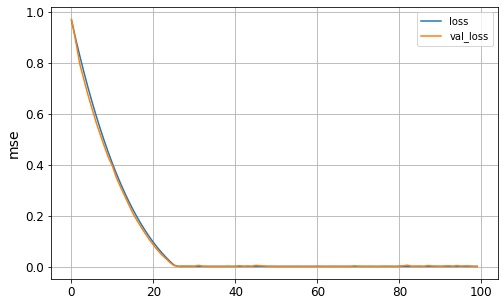

In [ ]:
valid_split = int(0.9 * ohlcv_histories_normalised.shape[0])

ohlcv_train = ohlcv_histories_normalised[:valid_split]
tech_ind_train = technical_indicators_normalised[:valid_split]
y_train = y_scaler.fit_transform(next_day_adj_close[:valid_split])

ohlcv_test = ohlcv_histories_normalised[valid_split:]
tech_ind_test = technical_indicators_normalised[valid_split:]

# model architecture with two branches and regularizers

# define two sets of inputs
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')

# the first branch operates on the first input
x = LSTM(50, name='lstm_0', bias_regularizer=L1L2(l1=0.01, l2=0.01))(lstm_input)
x = Dropout(0.4, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)

# the second branch opreates on the second input
y = Dense(50, name='tech_dense_0',bias_regularizer=L1L2(l1=0.01, l2=0.01))(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.4, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = keras.layers.concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

z = Dense(50, activation="sigmoid", name='dense_pooling',bias_regularizer=L1L2(l1=0.01, l2=0.01))(combined)
z = Dense(1, activation="linear", name='dense_out')(z)

# our model will accept the inputs of the two branches and then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)
adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=50, epochs=100, shuffle=True, validation_split=0.3)

# plot performance of our model based on all three metrics
pd.DataFrame({key: model.history.history[key] for key in ["loss", "val_loss"]}).plot(figsize=(8, 5))   
plt.grid(True)
plt.ylabel("mse")
plt.show()

In [ ]:
# evaluation
y_test = model.predict([ohlcv_test, tech_ind_test])
y_test = y_scaler.inverse_transform(y_test)

# Visualising the results
fig = px.line()
fig.update_layout(
    title="{}".format(stock_names[index]),
    xaxis_title="Opening Price",
    yaxis_title="Date")
fig.add_scatter(x=stock_data[index].index, y=stock_data[index]['Adj Close'], mode='lines', name="Real {} Stock Price".format(stock_names[index]))
fig.add_scatter(x=stock_data[index].index[n+history_points:], y=y_test.reshape(-1), mode='lines', fillcolor='red', name="Predicted {} Stock Price".format(stock_names[index]))
fig.show()

# calculate errors
real_mse = np.mean(np.square(y_test - next_day_adj_close[valid_split:]))
print("Real MSE: {}".format(real_mse))
scaled_mse = real_mse / (np.max(y_test) - np.min(y_test))
print("Scaled MSE: {}".format(scaled_mse))

Real MSE: 5.9431022669034625
Scaled MSE: 0.2148782292146578


As you can see, the multi branch model did a lot better than a simple model, with scaled mse of 0.21 compared to 1.01. This presumable can be improved even further with hyperparameter tuning, or using various other types of neural networks and adding more technical indicators to our model.

In [ ]:
trading_algo(index, y_test)
random_algo(index, y_test)


*** Let's start with a simple trading model - we buy when our predicted price tomorrow increases by >= 3 percent compared to today's actual price, and sell when the predicted price tomorrow drops by >=3 percent compared to today's actual price***
We start when the stock price is: $66.06
Total Cash on Hand: $100,000.00
Total Stock on Hand: $100,000.00 (1,513.8737 units worth $66.06 each)



,Order,Date,Price,# of stocks
0,Buy,2019-03-18,$66.06,"1,513.8737"
1,Sell,2020-03-13,$56.50,"3,027.7473"
2,Buy,2020-03-16,$50.00,"3,421.3545"



Total Cash on Hand: $0.00
Total Stock on Hand: $196,727.88 (3,421.3545 units worth $57.50 each)
Total Profit: $-3,272.12 over 382 days

*** Had we held to stock without selling: ***
Total Cash on Hand: $100,000.00
Total Stock on Hand: $87,047.74 (1,513.8737 units worth $57.50 each)
Total Profit: $-12,952.26 over 382 days

*** This is a random model - there's a 50/50 chance of buying or selling every single day ***



,Order,Date,Price,# of stocks
0,Buy,2019-03-18,$66.06,"1,513.8737"
1,Sell,2019-03-25,$66.80,"3,027.7473"
2,Buy,2019-03-26,$66.80,"3,027.7473"
3,Sell,2019-03-27,$66.55,"3,027.7473"
4,Buy,2019-03-28,$66.80,"3,016.5749"
...,...,...,...,...
194,Buy,2020-09-30,$56.50,"2,581.3412"
195,Sell,2020-10-01,$56.50,"2,581.3412"
196,Buy,2020-10-02,$56.00,"2,604.3889"
197,Sell,2020-10-05,$56.25,"2,604.3889"



Total Cash on Hand: $0.00
Total Stock on Hand: $151,776.04 (2,639.5833 units worth $57.50 each)
Total Profit: $-48,223.96 over 382 days
